#### ロジスティック写像の時系列クラスタリング

やること

- 時系列データを3000個ほど用意し、訓練データとテストデータにわける
- 訓練データから10個ずつのデータを作る->3個のほうが特徴が出やすいかも
- グラフでデータを確認
- TimeSeriesKmeansを用いてクラスタリング(何個にするかは考える)
- 作ったモデルにテストデータを入れてグラフで確認



インポート

In [1]:
#各種のインポート
import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary #torchinfoはニューラルネットの中身を見れるのでおすすめ
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import random

#乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

データ作成

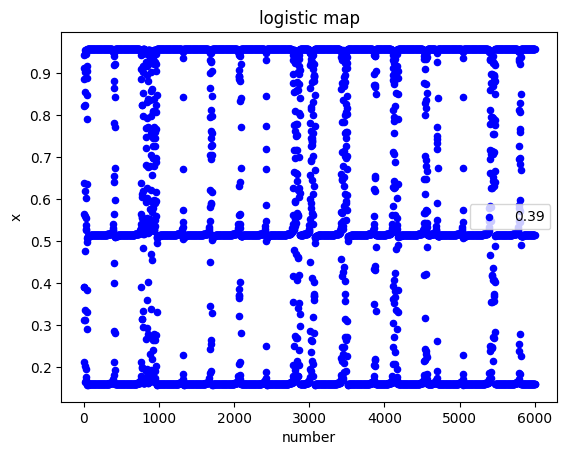

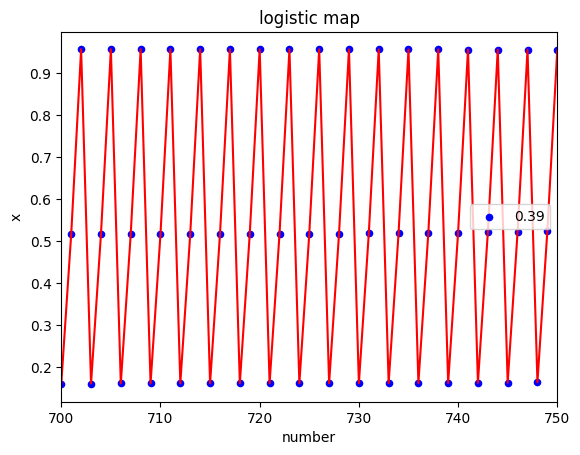

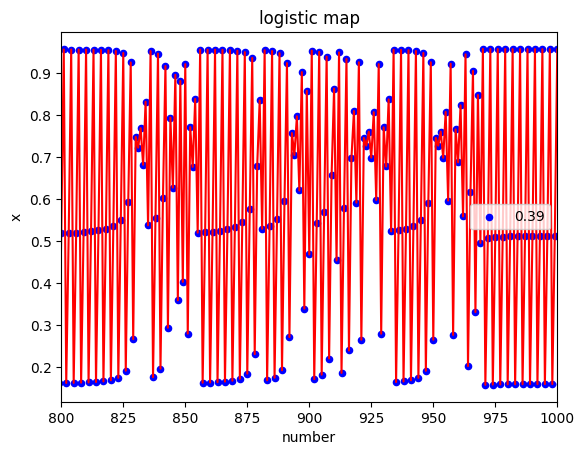

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

x_data = []
y_data = [] #ここにデータを入れていく
x_init = 0.39  #xの初期値
x_data.append(x_init)
a = 1+np.sqrt(8)-0.00001    #aの値を設定
n = 6000        #n個データを作る
def function(x):    #ロジスティック写像
    y = a*x*(1-x)
    return y
for i in range(n):
    y = function(x_data[-1])
    y_data.append(y)
    if i == n-1:
        break
    x_data.append(y_data[-1])

# DataFrameの作成
df = pd.DataFrame(x_data)

# CSVファイルとして保存
df.to_csv('data.csv', index=False)



# グラフ作成用インデックス
data = np.arange(0, n)
df_number = pd.DataFrame(data)


#データをPandasで読み込み
df = pd.read_csv("data.csv")


plt.scatter(df_number,df,color='blue',s=20, label="{}".format(x_init))
plt.xlabel("number")
plt.ylabel("x")
plt.title("logistic map")
plt.legend()
plt.show()
plt.close()

plt.scatter(df_number,df,color='blue',s=20, label="{}".format(x_init))
plt.plot(df_number,df,color='red')
plt.xlabel("number")
plt.ylabel("x")
plt.title("logistic map")
plt.legend()
plt.xlim(700, 750)
plt.show()
plt.close()

plt.scatter(df_number,df,color='blue',s=20, label="{}".format(x_init))
plt.plot(df_number,df,color='red')
plt.xlabel("number")
plt.ylabel("x")
plt.title("logistic map")
plt.legend()
plt.xlim(800, 1000)
plt.show()
plt.close()




10個ずつのデータを作成

In [3]:
number_step = 10
subsequences = [df[i:i+number_step] for i in range(len(df) - (number_step-1))]
subsequences_np = np.array(subsequences)
print(subsequences_np)

[[[0.39      ]
  [0.91078043]
  [0.31109501]
  ...
  [0.63718055]
  [0.8850592 ]
  [0.38946263]]

 [[0.91078043]
  [0.31109501]
  [0.82048686]
  ...
  [0.8850592 ]
  [0.38946263]
  [0.91032673]]

 [[0.31109501]
  [0.82048686]
  [0.56388057]
  ...
  [0.38946263]
  [0.91032673]
  [0.31252126]]

 ...

 [[0.51449912]
  [0.95629945]
  [0.15999264]
  ...
  [0.95629476]
  [0.16000904]
  [0.51456279]]

 [[0.95629945]
  [0.15999264]
  [0.51452011]
  ...
  [0.16000904]
  [0.51456279]
  [0.95629237]]

 [[0.15999264]
  [0.51452011]
  [0.95629712]
  ...
  [0.51456279]
  [0.95629237]
  [0.1600174 ]]]


データをto_time_series_datasetして訓練データとテストデータに分ける

c:\Users\kazuy\OneDrive\Labintern\VE\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


train size: 2398, test size: 600 
[[[0.39      ]
  [0.91078043]
  [0.31109501]
  ...
  [0.63718055]
  [0.8850592 ]
  [0.38946263]]

 [[0.91078043]
  [0.31109501]
  [0.82048686]
  ...
  [0.8850592 ]
  [0.38946263]
  [0.91032673]]

 [[0.31109501]
  [0.82048686]
  [0.56388057]
  ...
  [0.38946263]
  [0.91032673]
  [0.31252126]]

 ...

 [[0.16152578]
  [0.51850244]
  [0.95579366]
  ...
  [0.51989145]
  [0.95558949]
  [0.16247119]]

 [[0.51850244]
  [0.95579366]
  [0.16175882]
  ...
  [0.95558949]
  [0.16247119]
  [0.52094918]]

 [[0.95579366]
  [0.16175882]
  [0.51910618]
  ...
  [0.16247119]
  [0.52094918]
  [0.95542411]]]


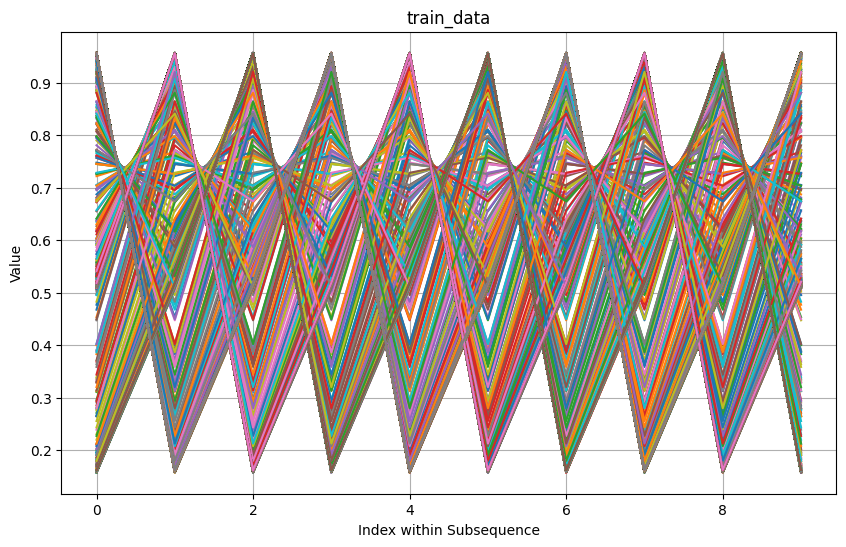

In [4]:
from tslearn.utils import to_time_series_dataset
formatted_data = to_time_series_dataset(subsequences_np[0:2998])
new_data = to_time_series_dataset(subsequences_np[2998:5998])
train_size = int(len(formatted_data) * 0.80) #学習サイズ
test_size = len(formatted_data) - train_size #全データから学習サイズを引けばテストサイズになる
train = formatted_data[0:train_size,:] #全データから学習の個所を抜粋
test = formatted_data[train_size:len(formatted_data),:] #全データからテストの個所を抜粋
print("train size: {}, test size: {} ".format(len(train), len(test)))
print(train)
plt.figure(figsize=(10, 6)) 
for i in range(len(train)):
    plt.plot(train[i], label=f'Sequence {i+1}') 
plt.title('train_data') 
plt.xlabel('Index within Subsequence') 
plt.ylabel('Value') 
#plt.legend() 
plt.grid(True) 
plt.show()

#### こっからクラスタリング

In [5]:
from tslearn.clustering import TimeSeriesKMeans

# クラスタリングモデルを定義
num_clusters=6
model = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", max_iter=10, random_state=0)

# モデルをデータにフィットさせる
train_labels = model.fit_predict(train)

print(train_labels)


[5 3 2 ... 2 1 0]


#### 学習したモデルを確認

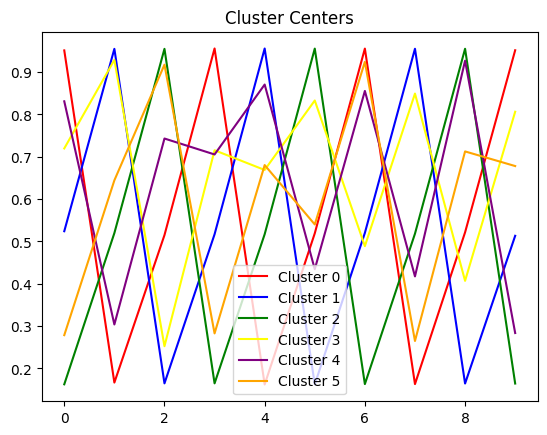

In [6]:
# クラスタごとの色
cluster_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'purple',
    5: 'orange',
    6: 'brown',
    7: 'c',
    8: 'm',
    9: '0.2',
    10: '0.3',
    11: '0.4',
    12: '0.5',
    13: '0.6',
    14: '0.7',
    15: '0.8',
    16: '0.9'
}

# クラスタ中心をプロット
for i, center in enumerate(model.cluster_centers_):
    plt.plot(center.flatten(), label=f'Cluster {i}', color=cluster_colors[i])
plt.title("Cluster Centers")
plt.legend()
plt.show()

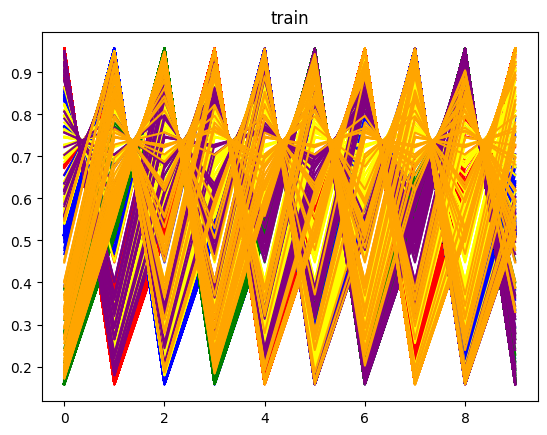

In [7]:
# 各クラスタのデータをプロット
for i in range(model.n_clusters):
    cluster_data = train[train_labels == i]
    for series in cluster_data:
        plt.plot(series.flatten(), label=f'Cluster {i}', color=cluster_colors[i])
plt.title("train")
#plt.legend()
plt.show()

#### テストデータで確認

In [8]:
# 新規データのクラスタ割り当てを予測
test_labels = model.predict(test)

print(test_labels)


[2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 5 5 4 5 4 4 5 4 1 0 1 1 0 2 1 0
 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2
 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1
 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0
 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2
 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1
 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0
 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2
 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1
 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0
 2 1 0 2 1 0 2 1 0 2 1 4 5 4 3 5 3 3 5 3 4 4 5 4 1 0 1 1 0 2 1 0 2 1 0 2 1
 0 5 5 3 2 3 3 5 3 3 3 3 4 5 3 4 1 0 1 1 0 2 3 4 5 3 3 5 3 4 3 4 5 3 4 1 0
 1 1 4 5 4 4 5 4 4 5 1 1 4 5 4 4 5 3 3 2 3 5 3 5 3 3 3 4 5 3 4 4 5 1 1 0 2
 1 0 2 1 0 2 1 0 2 1 0 2 

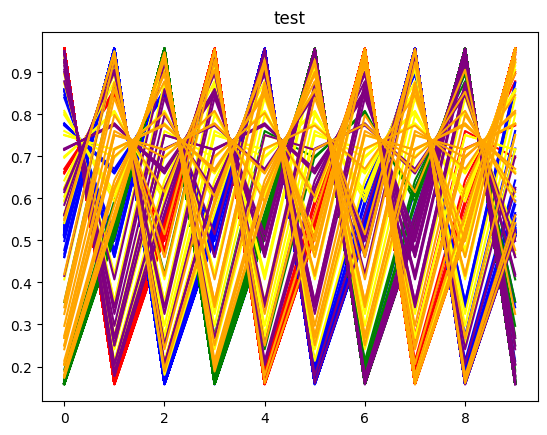

In [9]:
# 各クラスタのデータをプロット
for i in range(model.n_clusters):
    cluster_data = test[test_labels == i]
    for series in cluster_data:
        plt.plot(series.flatten(), label=f'Cluster {i}', color=cluster_colors[i])
plt.title("test")
#plt.legend()
plt.show()

#### 異常検知(訓練データとテストデータで)

[0,1,2]の異常は2の異常とする


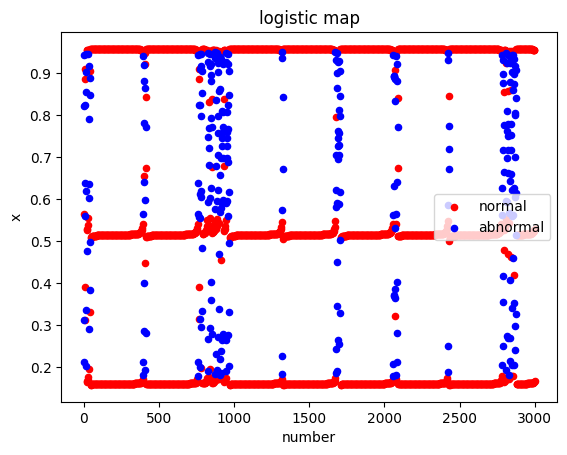

In [10]:
labels = model.predict(formatted_data)

plt.scatter(df_number[2:3000][labels==0],df[2:3000][labels==0],color='red',s=20, label="normal")
plt.scatter(df_number[2:3000][labels==1],df[2:3000][labels==1],color='red',s=20)
plt.scatter(df_number[2:3000][labels==2],df[2:3000][labels==2],color='red',s=20)
plt.scatter(df_number[2:3000][labels==3],df[2:3000][labels==3],color='blue',s=20, label="abnormal")
for i in range(num_clusters-4):
    plt.scatter(df_number[2:3000][labels==4+i],df[2:3000][labels==4+i],color='blue',s=20)
plt.xlabel("number")
plt.ylabel("x")
plt.title("logistic map")
plt.legend()
plt.show()
plt.close()

#### 異常検知(新規データ)

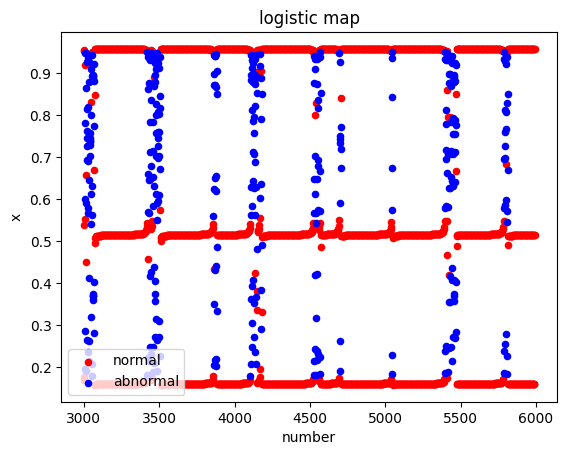

In [11]:
labels = model.predict(new_data)

plt.scatter(df_number[3000:6000-7][labels==0],df[3000:6000-7][labels==0],color='red',s=20, label="normal")
plt.scatter(df_number[3000:6000-7][labels==1],df[3000:6000-7][labels==1],color='red',s=20)
plt.scatter(df_number[3000:6000-7][labels==2],df[3000:6000-7][labels==2],color='red',s=20)
plt.scatter(df_number[3000:6000-7][labels==3],df[3000:6000-7][labels==3],color='blue',s=20, label="abnormal")
for i in range(num_clusters-4):
    plt.scatter(df_number[3000:6000-7][labels==4+i],df[3000:6000-7][labels==4+i],color='blue',s=20)
plt.xlabel("number")
plt.ylabel("x")
plt.title("logistic map")
plt.legend()
plt.show()
plt.close()

### これからやること
- SR法やSR-CNN